In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import plotly.express as px
%matplotlib inline

## LOADING DATA
<p><span style=\"color:black; font-family: 'Bebas Neue'; font-size: 1.3em;\">A complete dataset of traffic stops by police officers in the United States that was collected by <a href= "https://openpolicing.stanford.edu/data/">The stanford open policing project</a>. They have collected data from 31 states and in this notebook I'll be focusing on the data from the state of Tennessee.</span></p>

In [2]:
df = pd.read_csv(r"C:/Users/bdwum/Downloads/tn_nashville_2020_04_01.csv", low_memory=False)
print(df.head())
print(df.isnull().sum())

  raw_row_number        date      time  \
0         232947  2010-10-10       NaN   
1         237161  2010-10-10  10:00:00   
2         232902  2010-10-10  10:00:00   
3         233219  2010-10-10  22:00:00   
4         232780  2010-10-10  01:00:00   

                                            location        lat        lng  \
0  DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...  36.187925 -86.798519   
1            1122 LEBANON PIKE, NASHVILLE, TN, 37210  36.155521 -86.735902   
2                       898 DAVIDSON DR, , TN, 37205  36.117420 -86.895593   
3  MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...  36.086799 -86.648581   
4                      BUCHANAN ST, NORTH, TN, 37208  36.180038 -86.809109   

  precinct  reporting_area zone  subject_age  ... raw_traffic_citation_issued  \
0        6          4403.0  611         27.0  ...                       False   
1        5          9035.0  513         18.0  ...                        True   
2        1          5005.0  121    

## CLEANING DATA

Often, a DataFrame will contain columns that are not useful to your analysis. Such columns should be dropped from the DataFrame, to make it easier for you to focus on the remaining columns. Also missing data and column types should be taken into account.

In this notebook, I'll drop the columns containing large missing values because they contain no useful information and also check the column types

In [3]:
print("The dimentionality of the dataframe is: ", df.shape)
df.drop(["contraband_found", "contraband_drugs", "contraband_weapons", 
         "search_basis", "notes", "raw_misd_state_citation_issued", "raw_written_warning_issued",
         "precinct"], axis="columns", inplace=True)
print("Dimentionality after dropping columns: ", df.shape)

The dimentionality of the dataframe is:  (3092351, 42)
Dimentionality after dropping columns:  (3092351, 34)


In [4]:
df = df.dropna()
print(df.isnull().sum())
print(print(df.shape))

raw_row_number                 0
date                           0
time                           0
location                       0
lat                            0
lng                            0
reporting_area                 0
zone                           0
subject_age                    0
subject_race                   0
subject_sex                    0
officer_id_hash                0
type                           0
violation                      0
arrest_made                    0
citation_issued                0
warning_issued                 0
outcome                        0
frisk_performed                0
search_conducted               0
search_person                  0
search_vehicle                 0
reason_for_stop                0
vehicle_registration_state     0
raw_verbal_warning_issued      0
raw_traffic_citation_issued    0
raw_suspect_ethnicity          0
raw_driver_searched            0
raw_passenger_searched         0
raw_search_consent             0
raw_search

In [5]:
print(df.dtypes)

raw_row_number                  object
date                            object
time                            object
location                        object
lat                            float64
lng                            float64
reporting_area                 float64
zone                            object
subject_age                    float64
subject_race                    object
subject_sex                     object
officer_id_hash                 object
type                            object
violation                       object
arrest_made                     object
citation_issued                 object
warning_issued                  object
outcome                         object
frisk_performed                 object
search_conducted                object
search_person                   object
search_vehicle                  object
reason_for_stop                 object
vehicle_registration_state      object
raw_verbal_warning_issued       object
raw_traffic_citation_issu

In [6]:
df['raw_search_arrest'] = df.raw_search_arrest.astype('bool')
df['raw_search_consent'] = df.raw_search_arrest.astype('bool')
df['raw_verbal_warning_issued'] = df.raw_verbal_warning_issued.astype('bool')
df['raw_driver_searched'] = df.raw_driver_searched.astype('bool')
df['raw_search_warrant'] = df.raw_search_warrant.astype('bool')
combined = df.date.str.cat(df.time, sep= " ")
df['stop_datetime'] = pd.to_datetime(combined)
df.set_index('stop_datetime', inplace= True)
print(df.index)

DatetimeIndex(['2010-10-10 10:00:00', '2010-10-10 10:00:00',
               '2010-10-10 22:00:00', '2010-10-10 01:00:00',
               '2010-10-10 10:04:00', '2010-10-10 10:05:00',
               '2010-10-10 10:07:00', '2010-10-10 10:10:00',
               '2010-10-10 22:11:00', '2010-10-10 10:13:00',
               ...
               '2016-09-09 09:54:00', '2016-09-09 09:54:00',
               '2016-09-09 09:54:00', '2016-09-09 09:54:00',
               '2016-09-09 09:54:00', '2016-09-09 09:54:00',
               '2016-09-09 09:54:00', '2016-09-09 21:54:00',
               '2016-09-09 09:56:00', '2016-09-09 09:56:00'],
              dtype='datetime64[ns]', name='stop_datetime', length=2552374, freq=None)


## EXPLORING DATA

###  Examing traffic violations
Violations committed by all drivers

In [7]:
print(df.violation.value_counts())

moving traffic violation       1239013
vehicle equipment violation     853423
safety violation                158294
registration                    156706
seatbelt violation               88838
investigative stop               48214
parking violation                 6920
child restraint                    966
Name: violation, dtype: int64


### Comparing violations by gender
The question we're trying to answer is whether male and female drivers tend to commit different types of traffic violations.

In [8]:
# Create a Dataframe of female drivers
female = df[df['subject_sex'] == 'female']

# Create a Dataframe of male drivers
male = df[df['subject_sex'] == 'male']

# Compute the violations by female drivers (as proportions)
print(" Female violations\n", "-"*17, "\n", female.violation.value_counts(normalize= True), "\n")

# Compute the violations by male drivers (as proportions)
print(" Male violations\n", "-"*15, "\n",male.violation.value_counts(normalize= True))

 Female violations
 ----------------- 
 moving traffic violation       0.492102
vehicle equipment violation    0.336177
registration                   0.062923
safety violation               0.061658
seatbelt violation             0.028063
investigative stop             0.015842
parking violation              0.002621
child restraint                0.000615
Name: violation, dtype: float64 

 Male violations
 --------------- 
 moving traffic violation       0.480828
vehicle equipment violation    0.333112
safety violation               0.062267
registration                   0.060341
seatbelt violation             0.039466
investigative stop             0.020996
parking violation              0.002774
child restraint                0.000215
Name: violation, dtype: float64


## Does gender affect who gets ticket for moving traffic?

### Comparing moving traffic outcomes by gender
When a driver is pulled over for moving traffic, many people believe that gender has an impact on whether the driver will receive a ticket or a warning. Let's find evidence of this in the dataset

 Outcome for Females
 -------------------- 
 warning     0.699823
citation    0.290441
arrest      0.009737
Name: outcome, dtype: float64 

 Outcome for Males
 ------------------ 
 warning     0.682509
citation    0.298024
arrest      0.019467
Name: outcome, dtype: float64


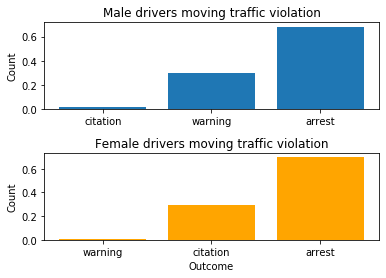

In [9]:
# Create a DataFrame of female drivers stopped for speeding
female_and_mt = df[(df.subject_sex == 'female') & (df.violation == 'moving traffic violation')]

# Create a DataFrame of male drivers stopped for speeding
male_and_mt = df[(df.subject_sex == 'male') & (df.violation == 'moving traffic violation')]

# Compute the stop outcomes for female drivers (as proportions)
print(" Outcome for Females\n", "-"*20, "\n", female_and_mt.outcome.value_counts(normalize=True), "\n")

# Compute the stop outcomes for male drivers (as proportions)
print(" Outcome for Males\n", "-"*18, "\n", male_and_mt.outcome.value_counts(normalize=True))

# Plot graph
fig, (ax1, ax2)= plt.subplots(2)
ax1.bar(male_and_mt.outcome.unique(), male_and_mt.outcome.value_counts(normalize=True).sort_values())
ax2.bar(female_and_mt.outcome.unique(), female_and_mt.outcome.value_counts(normalize=True).sort_values(), color='orange')
ax1.set_title('Male drivers moving traffic violation')
ax2.set_title('Female drivers moving traffic violation')
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')
ax2.set_xlabel('Outcome')
plt.subplots_adjust(hspace=0.5)
plt.show()

The numbers are similar for males and females: about 70% of stops for moving traffic result in a warning. Thus, the data fails to show that gender has an impact on who gets a ticket for moving traffic

## Does gender affect whose vehicle is searched?

### Calculating the search rate
During a traffic stop, the police officer sometimes conducts a search of the vehicle. Let's calculate the percentage of all stops that result in a vehicle search, also known as the search rate.

In [10]:
# Check the data type of 'search_conducted'
print(df.search_conducted.dtype)

# Change data type of 'search_conducted'
df['search_conducted'] = df.search_conducted.astype('bool')

# Calculate the search rate by counting the values
print(df.search_conducted.value_counts(normalize= True))

# Calculate the search rate by taking the mean
print("Search Rate: ", df.search_conducted.mean())

object
False    0.957896
True     0.042104
Name: search_conducted, dtype: float64
Search Rate:  0.04210354752085705


The search rate is about 4%. Next, we'll examine whether the search rate varies by driver gender

### Comparing search rates by gender

subject_sex
female    0.023981
male      0.054629
Name: search_conducted, dtype: float64


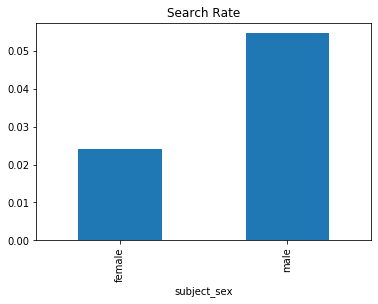

In [11]:
# Calculate the search rate for both groups simultaneously
print(df.groupby('subject_sex').search_conducted.mean())

# Plot graph
df.groupby('subject_sex').search_conducted.mean().plot(kind="bar", title='Search Rate')

Male drivers are searched more than twice as often as female drivers. Why might this be?
Even though the search rate for males is much higher than for females, it's possible that the difference is mostly due to a second factor.

For example, we might hypothesize that the search rate varies by violation type, and the difference in search rate between males and females is because they tend to commit different violations.

We can test this hypothesis by examining the search rate for each combination of gender and violation. If the hypothesis is true, we would find that males and females are searched at about the same rate for each violation.

In [12]:
# Reverse the ordering to group by violation before gender
print(df.groupby(['violation', 'subject_sex']).search_conducted.mean())

violation                    subject_sex
child restraint              female         0.034321
                             male           0.061538
investigative stop           female         0.096157
                             male           0.188046
moving traffic violation     female         0.020305
                             male           0.047885
parking violation            female         0.025604
                             male           0.051123
registration                 female         0.025459
                             male           0.055891
safety violation             female         0.023369
                             male           0.049310
seatbelt violation           female         0.032726
                             male           0.062117
vehicle equipment violation  female         0.025035
                             male           0.055857
Name: search_conducted, dtype: float64


For all types of violations, the search rate is higher for males than for females, disproving our hypothesis.

## Does gender affect who is frisked during a search?

### Calculating frisk performed rate

In [13]:
# Check the data type of 'frisk_performed'
print(df.frisk_performed.dtype)

# Change data type of 'frisk_performed'
df['frisk_performed'] = df.frisk_performed.astype('bool')

# Calculate the search rate by frisk_performed
print(df.frisk_performed.value_counts(normalize= True))

# Calculate the frisk performed rate by taking the mean
print("Frisk performed rate:", df.frisk_performed.mean())

object
False    0.979472
True     0.020528
Name: frisk_performed, dtype: float64
Frisk performed rate: 0.02052794770672323


The frisk performed rate is about 2%. Next, we'll examine whether the search rate varies by driver gender

### Comparing frisk rates by gender
We'll compare the rates at which female and male drivers are frisked during a search. Are males frisked more often than females, perhaps because police officers consider them to be higher risk?

0.4875493188416586
subject_sex
female    0.368379
male      0.523706
Name: frisk_performed, dtype: float64


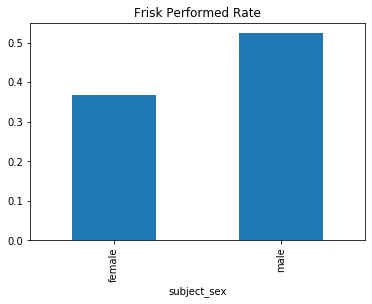

In [14]:
# Create a DataFrame of stops in which a search was conducted
searched = df[df.search_conducted == True]

# Calculate the overall frisk rate by taking the mean of 'frisk'
print(searched.frisk_performed.mean())

# Calculate the frisk rate for each gender
print(searched.groupby('subject_sex').frisk_performed.mean())

# Plot graph
searched.groupby('subject_sex').frisk_performed.mean().plot(kind='bar', title= 'Frisk Performed Rate')

The frisk rate is higher for males than for females, though we can't conclude that this difference is caused by the driver's gender.

## Does time of the day affect arrest rate?

### Calculating the hourly arrest rate
When a police officer stops a driver, a small percentage of those stops ends in an arrest. This is known as the arrest rate. We'll find out whether the arrest rate varies by time of day.

In [15]:
# Change arrest made data type
df["arrest_made"] = df.arrest_made.astype('bool')

# Calculate the overall arrest rate
print("Overall arrest rate: ", df.arrest_made.mean(), "\n")

# Calculate the hourly arrest rate
print("Hourly arrest rate: ", df.groupby(df.index.hour).arrest_made.mean())

# Save the hourly arrest rate
hourly_arrest_rate = df.groupby(df.index.hour).arrest_made.mean()

Overall arrest rate:  0.016666836443248522 

Hourly arrest rate:  stop_datetime
0     0.024691
1     0.036695
2     0.045419
3     0.045874
4     0.037727
5     0.021702
6     0.025035
7     0.006993
8     0.006900
9     0.008389
10    0.009259
11    0.010960
12    0.010153
13    0.011417
14    0.015551
15    0.010269
16    0.011630
17    0.013955
18    0.015006
19    0.013743
20    0.015407
21    0.018258
22    0.022306
23    0.018641
Name: arrest_made, dtype: float64


### Plotting the hourly arrest rate
We'll create a line plot from the hourly_arrest_rate object. A line plot is appropriate in this case because we are showing how a quantity changes over time.

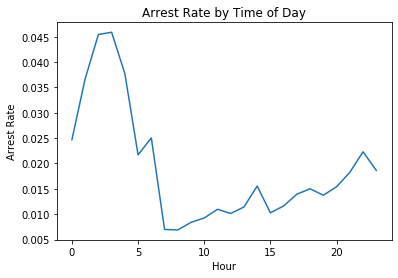

In [16]:
# Create a line plot of 'hourly_arrest_rate'
hourly_arrest_rate.plot()

# Add the xlabel, ylabel, and title
plt.xlabel("Hour")
plt.ylabel("Arrest Rate")
plt.title("Arrest Rate by Time of Day")

# Display the plot
plt.show()

From the plot we can see that the arrest rate has a significant spike overnight, and then dips in the early morning hours.

### Comparing arrest rate by race
We'll compare arrest rate by race and plot the results to see which race is mostly arrested on violations. But first, we have to see the number of traffic stops according to race in nashville

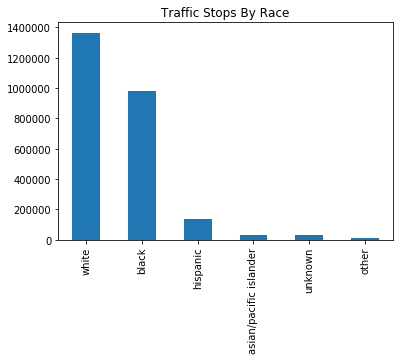

In [17]:
# Calculate traffic stop by race
race = df.subject_race.value_counts()

race.plot(kind='bar', title='Traffic Stops By Race')

We can see that whites are stopped more by the police followed by black people. Hispanics and Asians have a relatively low stop rate

subject_race
asian/pacific islander    0.007243
black                     0.022875
hispanic                  0.031937
other                     0.009123
unknown                   0.005531
white                     0.011219
Name: arrest_made, dtype: float64


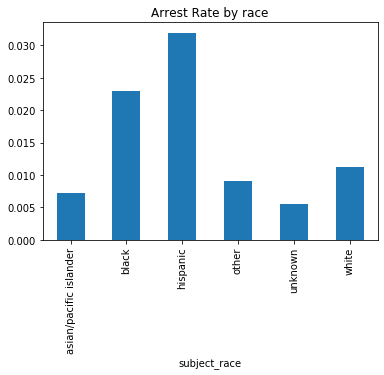

In [18]:
# Calculate arrest rate by race
print(df.groupby('subject_race').arrest_made.mean())

# Plot graph
df.groupby('subject_race').arrest_made.mean().plot(kind='bar', title= 'Arrest Rate by race')

Although hispanics have a low stop rate, they are the ones who are arrested the most by the police. Whites and Asian/Pacific Islanders have low rates while the rate of black people is also high.